# ML-8. Ансамблирование. Бэггинг, стекинг, бустинг

In [23]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

**Загрузка данных**

In [24]:
data = load_diabetes(as_frame=True)
X = data['frame']
y = data['target']

In [25]:
X.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019908 -0.017646   151.0  
1 -0.039493 -0.068330 -0.092204    75.0  
2 -0.002592  0.002864 -0.025930   141.0  
3  0.034309  0.022692 -0.009362   206.0  
4 -0.002592 -0.031991 -0.046641   135.0

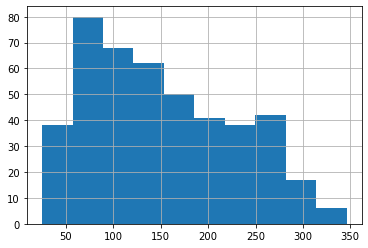

In [26]:
y.hist();

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [28]:
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

Размерность обучающей выборки (296, 11)
Размерность тестовой выборки (146, 11)


## Бэггинг: случайный лес. 


In [29]:
regr1 = DecisionTreeRegressor(max_depth=10, random_state=42)
regr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [30]:
regr2 = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)
regr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [31]:
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)

print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1),2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2),2)}')

Качество предсказания по MSE для решающего дерева 4.09
Качество предсказания по MSE для случайного леса  1.84


 ## Стекинг

In [32]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [33]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

#Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
#Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [34]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators_2 = [
    ('rcv', RidgeCV()),
    ('lr',  LinearRegression())
]

#Создаем объект класса стекинг
reg_2 = StackingRegressor(
    estimators=estimators_2,
    final_estimator=RandomForestRegressor(n_estimators=100,
                                          max_depth=10,
                                          random_state=42)
)
#Обучаем модель
reg_2.fit(X_train, y_train)

StackingRegressor(estimators=[('rcv',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lr', LinearRegression())],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        random_state=42))

In [35]:
y_pred_stack = reg.predict(X_test)
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack),2)}')

Качество предсказания по MSE для стекинга 0.82


In [36]:
y_pred_stack = reg_2.predict(X_test)
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack),1)}')

Качество предсказания по MSE для стекинга 0.3


In [37]:
meta_data = reg.transform(X_train)
#Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=['meta_feature1', 'meta_feature2',] #название столбцов
)
meta_df.head()


meta_feature1  meta_feature2
0     154.000000          154.0
1     192.000001          192.0
2     116.000002          116.0
3      81.000007           81.0
4     122.000005          122.0

 ## Бустинг
 



### Адаптивный бустинг

AdaBoost:

* base_estimator — параметр отвечает за природу базовых моделей, по умолчанию это DecisionTreeRegressor c максимальной глубиной (max_depth) 3.
* n_estimators — максимальное количество базовых моделей, по умолчанию равно 50. В случае идеального обучения алгоритм завершается ранее, чем данное значение.
* learning_rate — темп обучения, параметр, добавляющий дополнительный множитель весу базовой модели, по умолчанию он равен 1.
* loss{'linear', 'square', 'exponential'} — функция ошибки для обновления весов (в теоретической части мы рассматривали экспоненциальную форму обновления весов — 'exponential')
* random_state — параметр, фиксирующий случайные процессы в модели.

In [38]:
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=42
)

ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, 
    n_estimators=10
)
ada.fit(X_train, y_train)

ada_pred  = ada.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 40.5


In [44]:
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=42
)

ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, 
    n_estimators=50
)
ada.fit(X_train, y_train)

ada_pred  = ada.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 10.41


In [45]:
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=42
)

ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, 
    n_estimators=100
)
ada.fit(X_train, y_train)

ada_pred  = ada.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 10.15


### Градиентный бустинг (регрессия)

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    max_depth=3,
    n_estimators=100,
    random_state=42 
)
gb.fit(X_train, y_train)

gb_pred  = gb.predict(X_test)

print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 0.77


### Градиентный бустинг (классификация)

Основные параметры GradientBoostingRegressor:

loss — функция потерь. По умолчанию в регрессии 'squared_loss' - наша любимая MSE, а в классификации 'deviance' - логистическая функция потерь (logloss).

* learning_rate — темп обучения. По умолчанию 0.1. 
* n_estimators — количество деревьев в бустинга (число  из бустинга). По умолчанию равно 100.
* max_depth — максимальная глубина одного дерева. По умолчанию равна 3 — строятся короткие деревья с большим смещением.
* min_samples_leaf — минимальное число объектов в листе. По умолчанию 1.
* random_state — число, отвечающее за генерацию случайных чисел.

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
	max_depth=3, #максимальная глубина дерева
n_estimators=50, #количество деревьев
random_state=42 #генератор случайных чисел
)
gb.fit(X_train, y_train)
 
gb_pred  = gb.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для AdaBoost 0.91


In [57]:
gb_10 = GradientBoostingRegressor(
	max_depth=3, #максимальная глубина дерева
n_estimators=10, #количество деревьев
random_state=42 #генератор случайных чисел
)
gb_10.fit(X_train, y_train)
 
gb_pred_10  = gb_10.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, gb_pred_10),2)}')

Качество предсказания по MSE для AdaBoost 702.75


In [58]:
gb_100 = GradientBoostingRegressor(
	max_depth=3, #максимальная глубина дерева
n_estimators=100, #количество деревьев
random_state=42 #генератор случайных чисел
)
gb_100.fit(X_train, y_train)
 
gb_pred_100  = gb_100.predict(X_test)
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, gb_pred_100),2)}')

Качество предсказания по MSE для AdaBoost 0.77


In [59]:
df =pd.read_csv('data/winequality-red.csv', sep = ';')

In [60]:
df.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [61]:
X = df.drop(['quality'],axis = 1)
y = (df['quality'] >5).astype(int)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [63]:
gb = GradientBoostingClassifier(
    loss='deviance', #функция потерь
    learning_rate=0.1, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       238
           1       0.81      0.80      0.81       290

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528



In [64]:
gb.predict_proba(X_test)

array([[0.7575177 , 0.2424823 ],
       [0.81931477, 0.18068523],
       [0.80325657, 0.19674343],
       ...,
       [0.0212709 , 0.9787291 ],
       [0.90355559, 0.09644441],
       [0.80946194, 0.19053806]])

### Задание 4.6

Обучите на тренировочной выборке (X_train, y_train) модель градиентного бустинга, состоящего из 200 деревьев, максимальная глубина каждого из которых равна 3. Минимальное число объектов в листе — 10. Темп обучения возьмите равный 0.01. Параметр random_state установите в значение 42.

Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_train, y_train) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [65]:
gb_200 = GradientBoostingClassifier(
    loss='deviance', # функция потерь
    learning_rate=0.01, # темп обучения
    n_estimators=200, # число деревьев
    max_depth=3, # максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
gb_200.fit(X_train, y_train)
y_pred_200 = gb_200.predict(X_test)
print(classification_report(y_test, y_pred_200))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       238
           1       0.77      0.73      0.75       290

    accuracy                           0.73       528
   macro avg       0.73      0.73      0.73       528
weighted avg       0.73      0.73      0.73       528



### Задание 4.7

Увеличьте количество деревьев до 500, остальные параметры оставьте прежними.

Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_train, y_train) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [67]:
gb_500 = GradientBoostingClassifier(
    loss='deviance', # функция потерь
    learning_rate=0.01, # темп обучения
    n_estimators=500, # число деревьев
    max_depth=3, # максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
gb_500.fit(X_train, y_train)
y_pred_500 = gb_500.predict(X_test)
print(classification_report(y_test, y_pred_500))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       238
           1       0.79      0.76      0.77       290

    accuracy                           0.75       528
   macro avg       0.75      0.75      0.75       528
weighted avg       0.76      0.75      0.75       528



### Задание 4.8

Увеличьте learning rate до 0.2.

Сделайте предсказание качества вина для тренировочного и тестового набора данных. Рассчитайте метрику accuracy для тестового набора (X_train, y_train) и запишите её в качестве ответа с точностью до двух знаков после запятой.

accuracy на тестовой выборке:

In [72]:
gb_500_2 = GradientBoostingClassifier(
    loss='deviance', # функция потерь
    learning_rate=0.2, # темп обучения
    n_estimators=500, # число деревьев
    max_depth=3, # максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)
gb_500_2.fit(X_train, y_train)
y_pred_500_2 = gb_500_2.predict(X_test)
y_pred_2_train = gb_500_2.predict(X_train)
print('__________________X_test________________________')
print(classification_report(y_test, y_pred_500_2))

__________________X_test________________________
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       238
           1       0.81      0.83      0.82       290

    accuracy                           0.80       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.80      0.80      0.80       528

